# Plots

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [ ]:
def load_and_prepare_data(base_path='data'):
    pattern = os.path.join(base_path, '**', '*_averages.csv')
    csv_files = glob.glob(pattern, recursive=True)

    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the path: {base_path}")

    dfs = []
    for fpath in csv_files:
        parts = fpath.split(os.sep)

        if len(parts) < 3:
            print(f"Skipping file due to unexpected path structure: {fpath}")
            continue

        implementation_name = parts[1]  # e.g., 'sequential', 'fine_lock'
        op_mix_range = parts[2]          # e.g., '101080_shared'

        # Split 'op_mix_range' into 'op_mix' and 'range_type'
        if '_' not in op_mix_range:
            print(f"Skipping file due to unexpected op_mix_range format: {op_mix_range}")
            continue
        op_mix, range_type = op_mix_range.split('_', 1)  # split only on the first '_'

        filename = parts[-1]  # e.g., '1s_8threads_averages.csv'
        base_name = filename.replace('_averages.csv', '')
        splitted = base_name.split('_')

        if len(splitted) < 2:
            print(f"Skipping file due to unexpected filename format: {filename}")
            continue

        runtime_str = splitted[0].rstrip('s')  # remove trailing 's', e.g., '1'
        num_threads_str = splitted[1].replace('threads', '')  # remove 'threads', e.g., '8'

        try:
            runtime = int(runtime_str)
        except ValueError:
            print(f"Runtime conversion failed for value: {runtime_str} in file: {fpath}")
            runtime = runtime_str  # Keep as string if conversion fails

        # Read the CSV file
        try:
            df = pd.read_csv(fpath)
        except Exception as e:
            print(f"Failed to read CSV file: {fpath}. Error: {e}")
            continue

        # Add contextual columns
        df['implementation_name'] = implementation_name
        df['op_mix'] = op_mix
        df['range_type'] = range_type
        df['runtime_in_sec'] = runtime

        # Handle the 'threads' column
        if 'threads' in df.columns:
            if len(df['threads'].unique()) == 1:
                csv_threads = df['threads'].unique()[0]
                try:
                    filename_threads = int(num_threads_str)
                    if csv_threads != filename_threads:
                        print(f"Mismatch in threads for file: {fpath}. CSV: {csv_threads}, Filename: {num_threads_str}")
                except ValueError:
                    print(f"Invalid thread count in filename: {num_threads_str} for file: {fpath}")
        else:
            # If 'threads' column is missing in CSV, use extracted value
            try:
                df['threads'] = int(num_threads_str)
            except ValueError:
                print(f"Threads conversion failed for value: {num_threads_str} in file: {fpath}")
                df['threads'] = num_threads_str  # Keep as string if conversion fails

        # Drop unnecessary columns if present
        # Define columns to drop (if any)
        unnecessary_columns = []  # e.g., ['prefill_count', 'some_other_column']
        for col in unnecessary_columns:
            if col in df.columns:
                df.drop(columns=[col], inplace=True)

        # Sanitize the 'average_operations_per_thread' column
        if 'average_operations_per_thread' in df.columns:
            def sanitize_average_ops(x, fpath):
                if isinstance(x, str):
                    try:
                        # Safely evaluate the string to a Python literal
                        evaluated = ast.literal_eval(x)
                        # Ensure it's a list or tuple
                        if isinstance(evaluated, (list, tuple)):
                            return np.array(evaluated)
                        else:
                            print(f"Unexpected type after evaluation in file: {fpath}. Expected list or tuple, got {type(evaluated)}.")
                            return np.nan
                    except (ValueError, SyntaxError) as e:
                        print(f"Failed to parse 'average_operations_per_thread' in file: {fpath}. Error: {e}")
                        return np.nan
                elif isinstance(x, (list, tuple, np.ndarray)):
                    return np.array(x)
                else:
                    print(f"Unexpected data type in 'average_operations_per_thread' in file: {fpath}. Got {type(x)}.")
                    return np.nan

            df['average_operations_per_thread'] = df['average_operations_per_thread'].apply(
                lambda x: sanitize_average_ops(x, fpath)
            )

            # Optionally, drop rows where 'average_operations_per_thread' couldn't be parsed
            initial_len = len(df)
            df = df.dropna(subset=['average_operations_per_thread'])
            dropped_len = initial_len - len(df)
            if dropped_len > 0:
                print(f"Dropped {dropped_len} rows due to parsing errors in 'average_operations_per_thread' for file: {fpath}")

        dfs.append(df)

    if not dfs:
        raise ValueError("No valid data frames were created from the CSV files.")

    # Concatenate all DataFrames into a final DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    return final_df

# Example Usage
final_df = load_and_prepare_data()

# Separate DataFrames for specific conditions
df_sequential_101080 = final_df[
    (final_df['implementation_name'] == 'sequential') &
    (final_df['op_mix'] == "101080")
].copy()
df_sequential_101080['range_type'] = 'disjoint'

df_sequential_404020 = final_df[
    (final_df['implementation_name'] == 'sequential') &
    (final_df['op_mix'] == "404020")
].copy()
df_sequential_404020['range_type'] = 'disjoint'

# Concatenate the modified DataFrames back into final_df
final_df = pd.concat([final_df, df_sequential_404020, df_sequential_101080], ignore_index=True)

# Display the first few rows of the final DataFrame
display(final_df.head())


,threads,time,total_inserts,successful_inserts,total_deletes,successful_deletes,total_contains,successful_contains,total_operations,implementation_name,op_mix,range_type,runtime_in_sec,prefill_count,average_operations_per_thread
0,1,1.000001,116812.0,79902.0,105205.0,33274.0,832602.0,263173.0,1054619.0,global_lock,101080,shared,1,NaN,NaN
1,2,1.000002,120690.0,82221.0,108686.0,34925.0,859194.0,276386.0,1088570.0,global_lock,101080,shared,1,NaN,NaN
2,4,1.007134,86689.0,63409.0,77771.0,20932.0,616746.0,166120.0,781206.0,global_lock,101080,shared,1,NaN,NaN
3,8,1.000021,85343.0,62445.0,76419.0,20312.0,606140.0,161878.0,767902.0,global_lock,101080,shared,1,NaN,NaN
4,10,1.000038,87899.0,64211.0,78085.0,21291.0,624131.0,170240.0,790115.0,global_lock,101080,shared,1,NaN,NaN


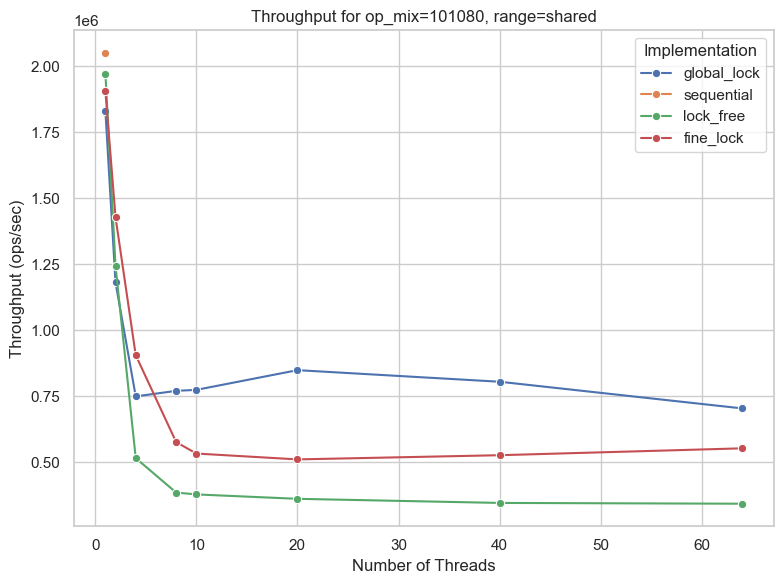

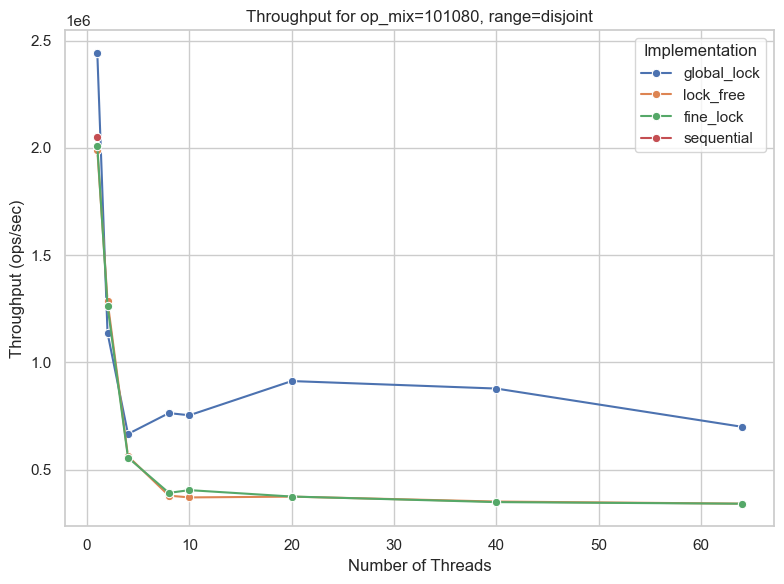

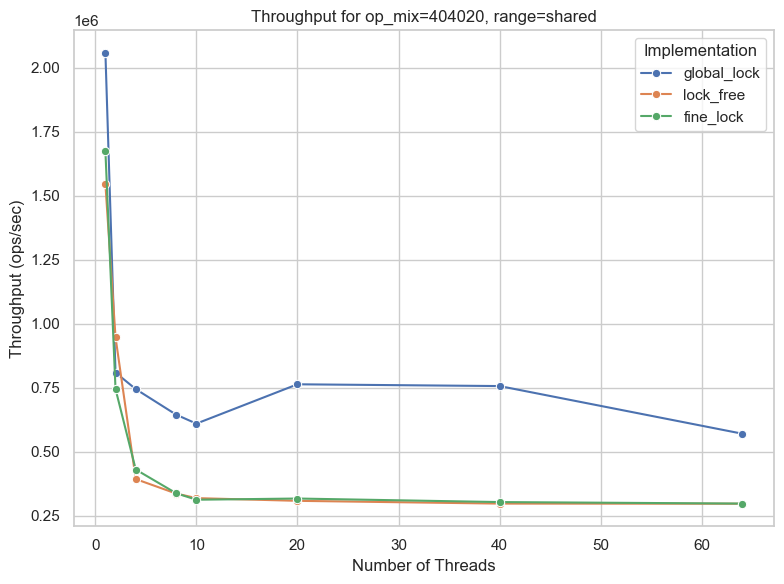

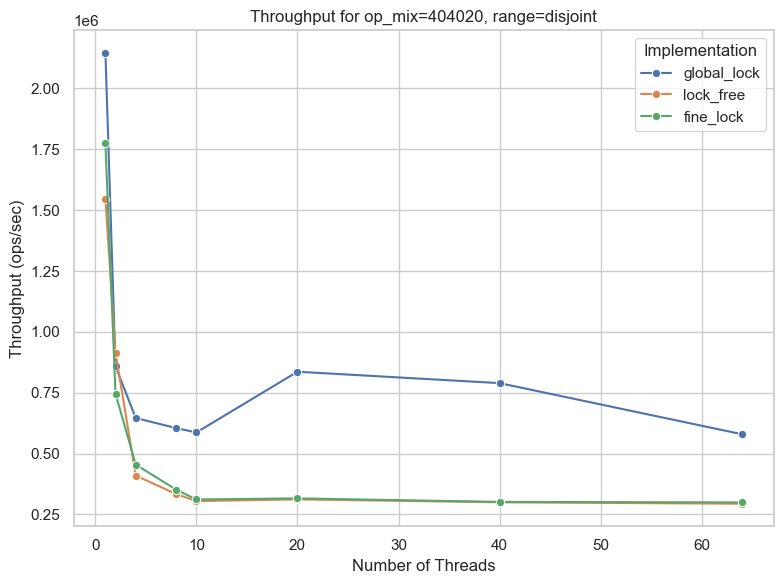

In [ ]:
def plot_throughput(df, op_mix, range_type, store=False):
    df_filtered = df.loc[
        (df['op_mix'] == op_mix) & 
        (df['range_type'] == range_type)
    ].copy()

    df_filtered['throughput'] = df_filtered['total_operations'] / df_filtered['time']

    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=df_filtered, 
        x='threads', 
        y='throughput', 
        hue='implementation_name', 
        marker='o',
        errorbar=None
    )

    plt.title(f"Throughput for op_mix={op_mix}, range={range_type}")
    plt.xlabel("Number of Threads")
    plt.ylabel("Throughput (ops/sec)")
    plt.legend(title="Implementation")
    plt.tight_layout()
    if store:
        plt.savefig(f"throughput_{op_mix}_{range_type}.png", dpi=300)
    else:
        plt.show()

plot_throughput(final_df, '101080', 'shared')
plot_throughput(final_df, '101080', 'disjoint')
plot_throughput(final_df, '404020', 'shared')
plot_throughput(final_df, '404020', 'disjoint')

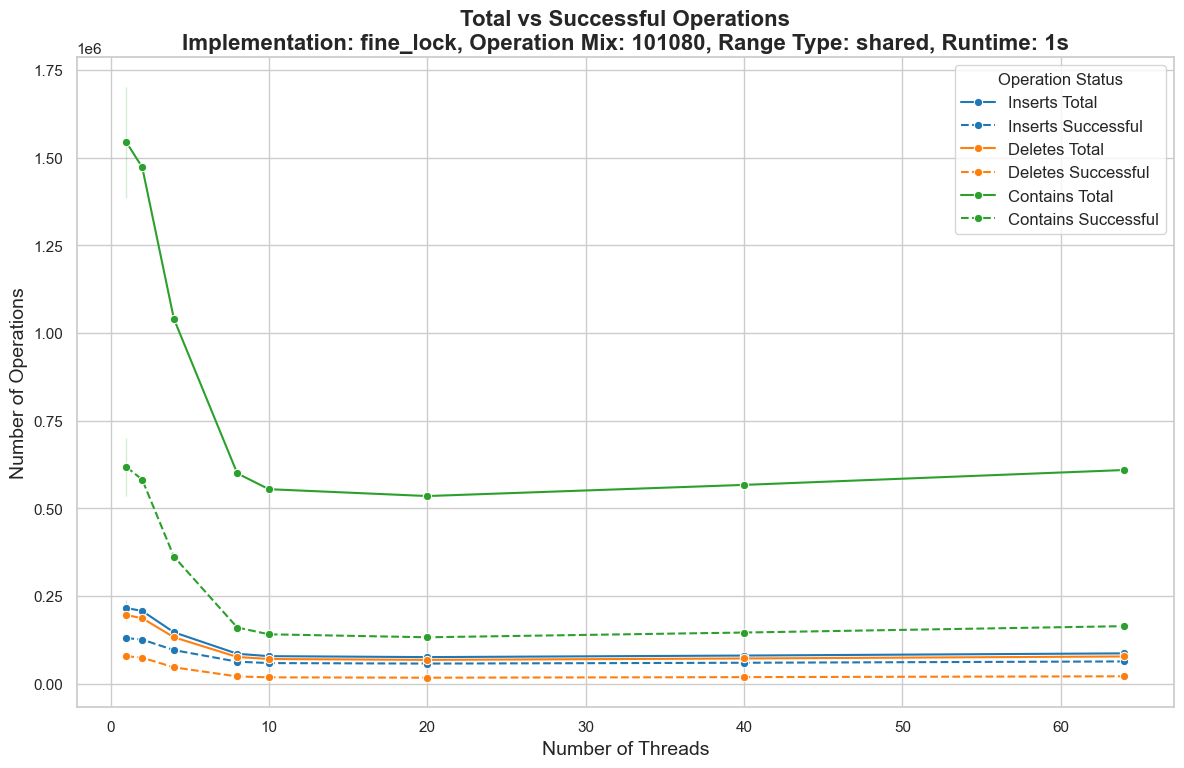

In [105]:
def print_total_vs_successful_operations(df, implementation_name, op_mix, range_type, runtime_in_sec):
    # Step 1: Filter the DataFrame based on the provided parameters
    filtered_df = df[
        (df['implementation_name'] == implementation_name) &
        (df['op_mix'] == op_mix) &
        (df['range_type'] == range_type) &
        (df['runtime_in_sec'] == runtime_in_sec)
    ]
    
    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        print("No data found for the specified parameters.")
        return
    
    # Step 2: Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    # Step 3: Initialize the plot
    plt.figure(figsize=(12, 8))
    
    # Define color palette for operations
    palette = {
        'Inserts': 'tab:blue',
        'Deletes': 'tab:orange',
        'Contains': 'tab:green'
    }
    
    # Define line styles for statuses
    linestyles = {
        'Total': 'solid',
        'Successful': 'dashed'
    }
    
    # List of operation types and their corresponding columns
    operations = {
        'Inserts': ('total_inserts', 'successful_inserts'),
        'Deletes': ('total_deletes', 'successful_deletes'),
        'Contains': ('total_contains', 'successful_contains')
    }
    
    # Step 4: Plot total and successful operations for each operation type
    for operation, (total_col, success_col) in operations.items():
        # Plot Total Operations
        sns.lineplot(
            data=filtered_df,
            x='threads',
            y=total_col,
            label=f'{operation} Total',
            color=palette[operation],
            linestyle=linestyles['Total'],
            marker='o'
        )
        
        # Plot Successful Operations
        sns.lineplot(
            data=filtered_df,
            x='threads',
            y=success_col,
            label=f'{operation} Successful',
            color=palette[operation],
            linestyle=linestyles['Successful'],
            marker='o'
        )
    
    # Step 5: Customize the plot
    plt.title(
        f"Total vs Successful Operations\n"
        f"Implementation: {implementation_name}, Operation Mix: {op_mix}, "
        f"Range Type: {range_type}, Runtime: {runtime_in_sec}s",
        fontsize=16,
        fontweight='bold'
    )
    
    plt.xlabel("Number of Threads", fontsize=14)
    plt.ylabel("Number of Operations", fontsize=14)
    
    plt.legend(title="Operation Status", fontsize=12, title_fontsize=12)
    
    plt.tight_layout()
    
    # Step 6: Display the plot
    plt.show()
    
    # plt.savefig(f"benchmark_{implementation_name}_{op_mix}_{range_type}_{runtime_in_sec}s.png", dpi=300)

# Example Usage
print_total_vs_successful_operations(final_df, 'fine_lock', '101080', 'shared', 1)

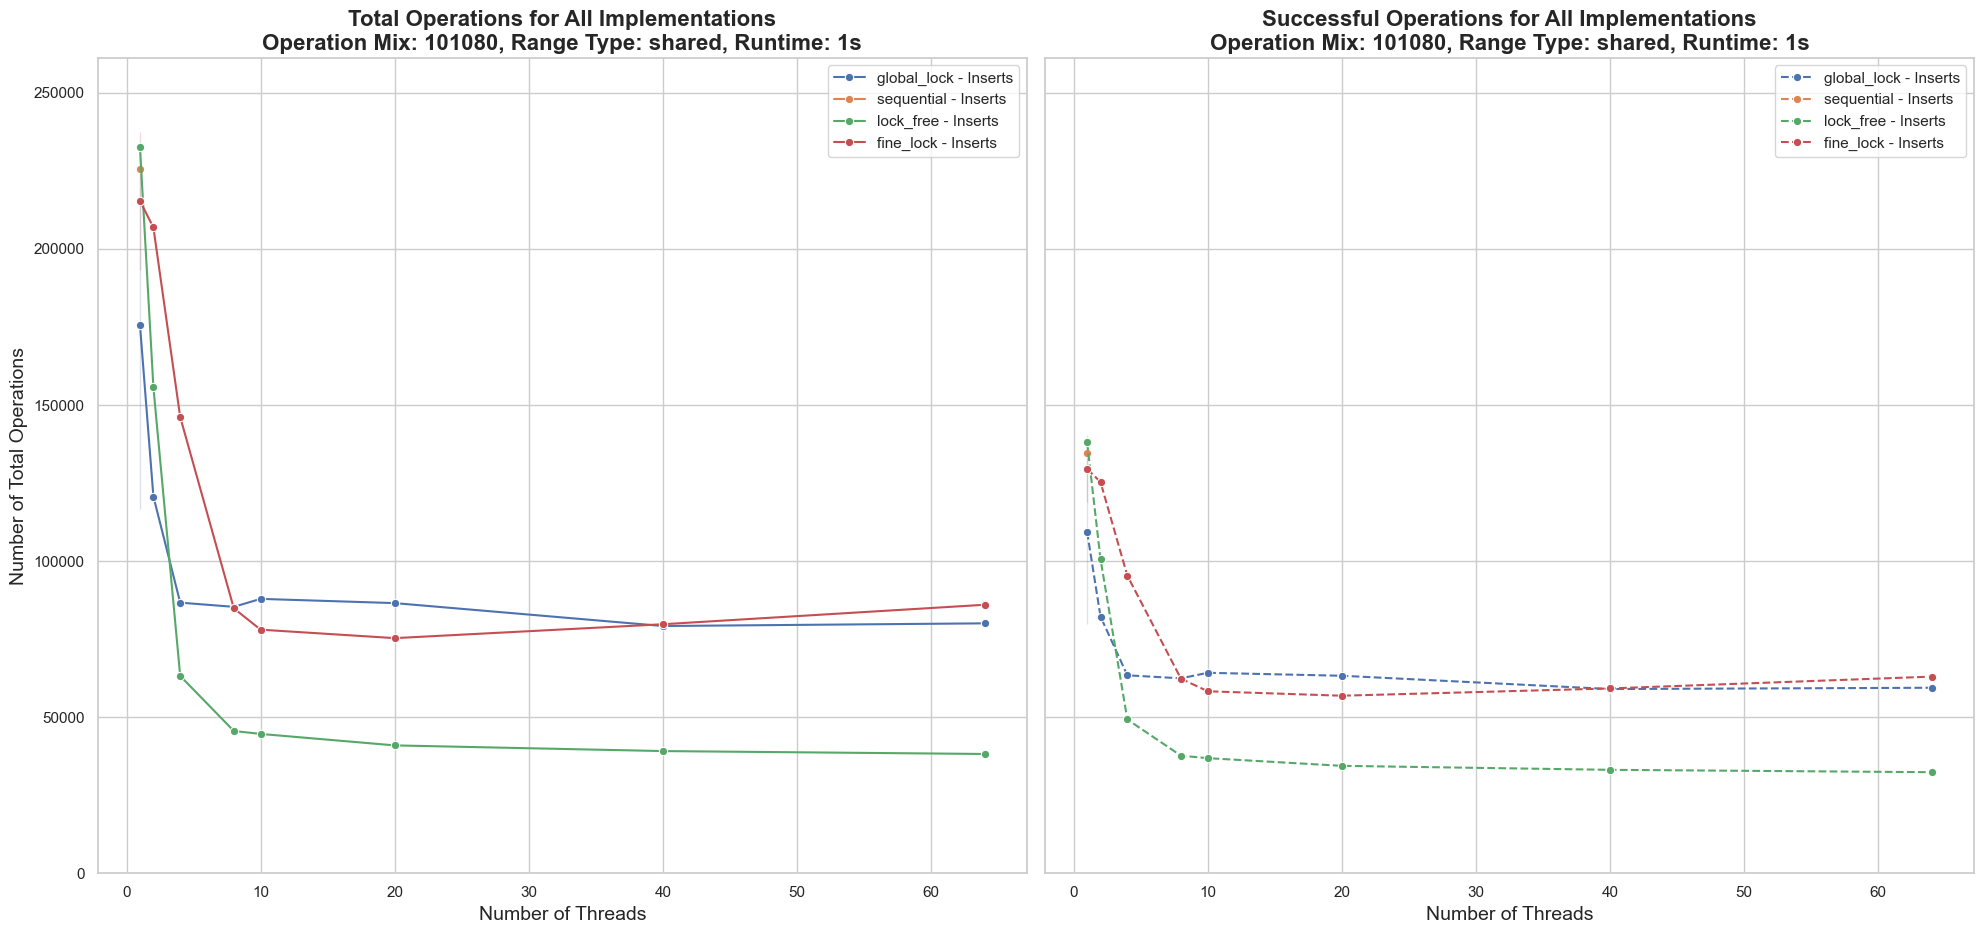

In [106]:
def plot_total_vs_successful_operations_all_implementations(df, op, op_mix, range_type, runtime_in_sec):
    filtered_df = df[
        (df['op_mix'] == op_mix) &
        (df['range_type'] == range_type) &
        (df['runtime_in_sec'] == runtime_in_sec)
    ]

    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        print("No data found for the specified parameters.")
        return

    # Step 2: Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Step 3: Initialize the subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)  # Set sharey=True
    ax_total, ax_success = axes

    # Define a color palette for different implementations
    implementation_names = filtered_df['implementation_name'].unique()
    num_implementations = len(implementation_names)
    palette = sns.color_palette(n_colors=num_implementations)
    implementation_color_map = dict(zip(implementation_names, palette))

    # Initialize variables to track the maximum y-value
    max_total = 0
    max_success = 0

    operation = op[0]
    total_col = op[1]
    success_col = op[2]

    # Step 4: Plot Total Operations
    for implementation in implementation_names:
        impl_df = filtered_df[filtered_df['implementation_name'] == implementation]

        sns.lineplot(
            data=impl_df,
            x='threads',
            y=total_col,
            label=f'{implementation} - {operation}',
            color=implementation_color_map[implementation],
            linestyle='solid',
            marker='o',
            ax=ax_total
        )

            # Update max_total if necessary
        current_max_total = impl_df[total_col].max()
        if current_max_total > max_total:
                max_total = current_max_total

    # Step 5: Plot Successful Operations
    for implementation in implementation_names:
        impl_df = filtered_df[filtered_df['implementation_name'] == implementation]

        sns.lineplot(
                data=impl_df,
                x='threads',
                y=success_col,
                label=f'{implementation} - {operation}',
                color=implementation_color_map[implementation],
                linestyle='dashed',
                marker='o',
                ax=ax_success,
            )

            # Update max_success if necessary
        current_max_success = impl_df[success_col].max()
        if current_max_success > max_success:
                max_success = current_max_success

    # Step 6: Determine the unified y-axis limit
    overall_max = max(max_total, max_success)
    y_limit = overall_max * 1.1  # Add 10% padding for better visualization

    # Step 7: Set the same y-axis limits for both subplots
    ax_total.set_ylim(0, y_limit)
    ax_success.set_ylim(0, y_limit)

    # Step 8: Customize the Total Operations subplot
    ax_total.set_title(
        f"Total Operations for All Implementations\n"
        f"Operation Mix: {op_mix}, Range Type: {range_type}, Runtime: {runtime_in_sec}s",
        fontsize=16,
        fontweight='bold'
    )
    ax_total.set_xlabel("Number of Threads", fontsize=14)
    ax_total.set_ylabel("Number of Total Operations", fontsize=14)

    # Step 9: Customize the Successful Operations subplot
    ax_success.set_title(
        f"Successful Operations for All Implementations\n"
        f"Operation Mix: {op_mix}, Range Type: {range_type}, Runtime: {runtime_in_sec}s",
        fontsize=16,
        fontweight='bold'
    )
    ax_success.set_xlabel("Number of Threads", fontsize=14)
    ax_success.set_ylabel("Number of Successful Operations", fontsize=14)

    # Step 11: Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust bottom to accommodate the legend

    # Step 12: Display the plot
    plt.show()

    # Optional: Save the plot to a file
    # plt.savefig(f"benchmark_all_implementations_{op_mix}_{range_type}_{runtime_in_sec}s.png", dpi=300, bbox_inches='tight'))

# Example Usage
# Assuming 'final_df' is your DataFrame containing all benchmark data
plot_total_vs_successful_operations_all_implementations(final_df, ('Inserts', 'total_inserts', 'successful_inserts'), '101080', 'shared', 1)

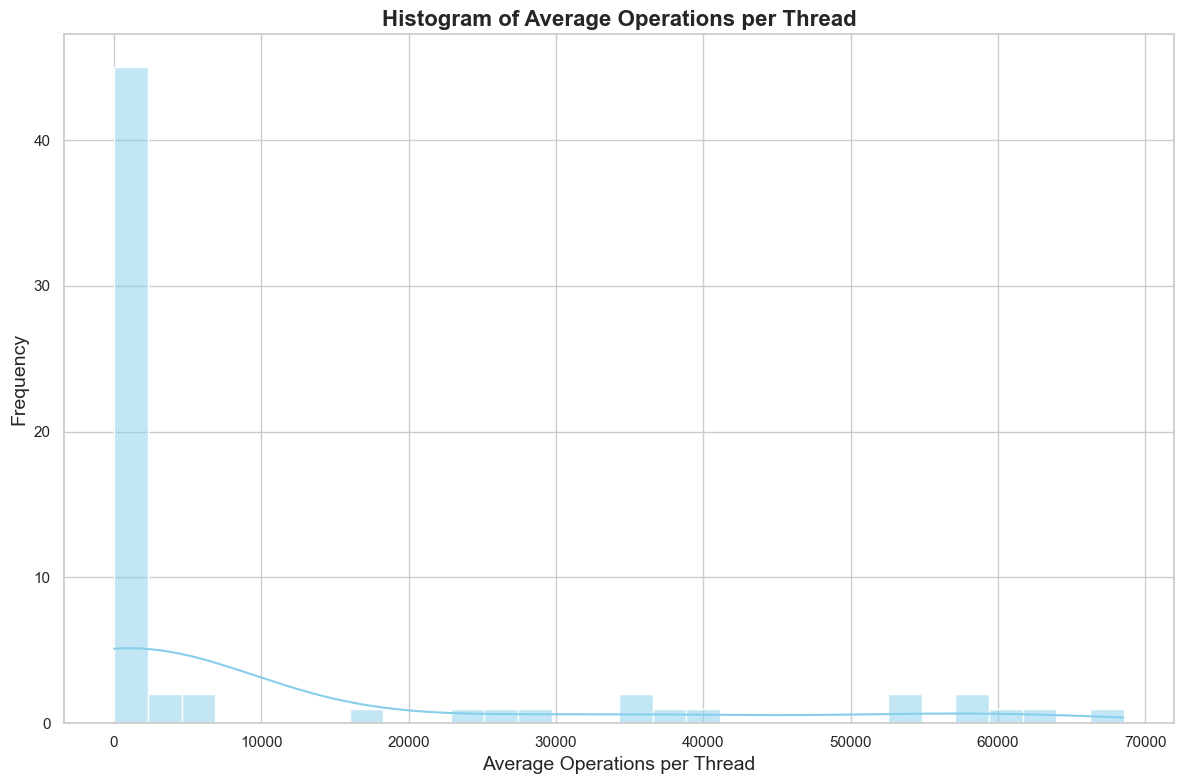

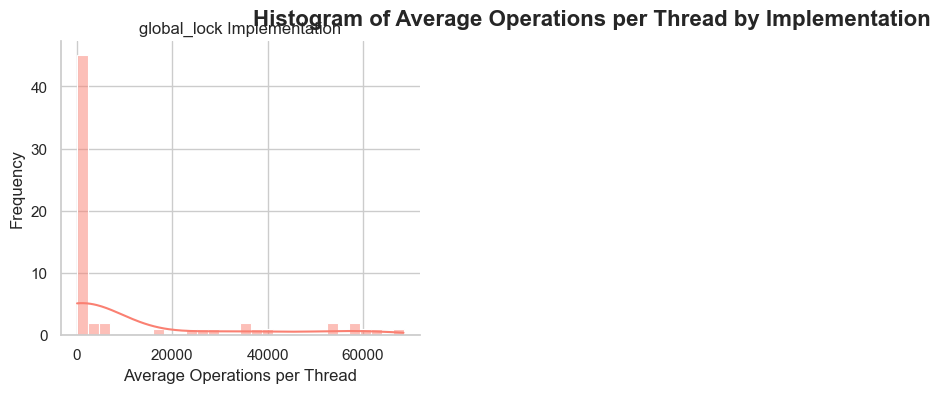

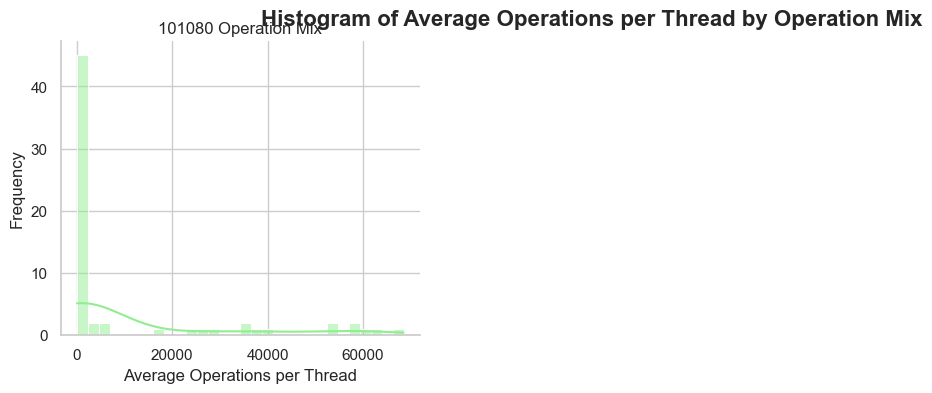

In [161]:
df = final_df[(final_df['implementation_name'] == 'global_lock') & (final_df['op_mix'] == '101080') & (final_df['range_type'] == 'disjoint') & (final_df['runtime_in_sec'] == 1)& (final_df['threads'] == 64) ]

# Plotting Functions
def plot_average_operations_histogram(df):
    """
    Plots a histogram of the average_operations_per_thread column.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    - None
    """
    # Extract the 'average_operations_per_thread' column
    avg_ops_col = df['average_operations_per_thread']

    # Initialize an empty list to hold all operations
    all_avg_ops = []

    # Iterate through each entry and extend the list
    for entry in avg_ops_col:
        if isinstance(entry, np.ndarray):
            all_avg_ops.extend(entry)
        elif isinstance(entry, list):
            all_avg_ops.extend(entry)
        else:
            # Handle unexpected types if any
            print(f"Unexpected type in 'average_operations_per_thread': {type(entry)}. Entry: {entry}")

    # Convert to Pandas Series for easier handling
    all_avg_ops_series = pd.Series(all_avg_ops)

    # Convert to numeric, coerce errors
    all_avg_ops_series = pd.to_numeric(all_avg_ops_series, errors='coerce')

    # Drop NaN values
    all_avg_ops_series = all_avg_ops_series.dropna()

    # Plot the histogram with KDE
    plt.figure(figsize=(12, 8))
    sns.histplot(all_avg_ops_series, bins=30, kde=True, color='skyblue')

    # Customize the plot
    plt.title('Histogram of Average Operations per Thread', fontsize=16, fontweight='bold')
    plt.xlabel('Average Operations per Thread', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Display the plot
    plt.tight_layout()
    plt.show()

def plot_faceted_histogram_by_implementation(df):
    """
    Plots faceted histograms of average_operations_per_thread grouped by implementation_name.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    - None
    """
    # Explode the 'average_operations_per_thread' column to have one value per row
    exploded_df = df.explode('average_operations_per_thread')

    # Convert to numeric and drop NaNs
    exploded_df['average_operations_per_thread'] = pd.to_numeric(exploded_df['average_operations_per_thread'], errors='coerce')
    exploded_df = exploded_df.dropna(subset=['average_operations_per_thread'])

    # Plot using FacetGrid
    g = sns.FacetGrid(exploded_df, col="implementation_name", col_wrap=3, height=4, sharex=True, sharey=True)
    g.map(sns.histplot, 'average_operations_per_thread', bins=30, kde=True, color='salmon')

    # Add titles and labels
    g.set_titles(col_template="{col_name} Implementation")
    g.set_axis_labels("Average Operations per Thread", "Frequency")

    # Adjust the main title
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Histogram of Average Operations per Thread by Implementation', fontsize=16, fontweight='bold')

    # Display the plot
    plt.show()

def plot_faceted_histogram_by_op_mix(df):
    """
    Plots faceted histograms of average_operations_per_thread grouped by op_mix.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    - None
    """
    # Explode the 'average_operations_per_thread' column to have one value per row
    exploded_df = df.explode('average_operations_per_thread')

    # Convert to numeric and drop NaNs
    exploded_df['average_operations_per_thread'] = pd.to_numeric(exploded_df['average_operations_per_thread'], errors='coerce')
    exploded_df = exploded_df.dropna(subset=['average_operations_per_thread'])

    # Plot using FacetGrid
    g = sns.FacetGrid(exploded_df, col="op_mix", col_wrap=3, height=4, sharex=True, sharey=True)
    g.map(sns.histplot, 'average_operations_per_thread', bins=30, kde=True, color='lightgreen')

    # Add titles and labels
    g.set_titles(col_template="{col_name} Operation Mix")
    g.set_axis_labels("Average Operations per Thread", "Frequency")

    # Adjust the main title
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Histogram of Average Operations per Thread by Operation Mix', fontsize=16, fontweight='bold')

    # Display the plot
    plt.show()

# Plot the general histogram
plot_average_operations_histogram(df)

# Plot faceted histograms by implementation
plot_faceted_histogram_by_implementation(df)

# Plot faceted histograms by operation mix
plot_faceted_histogram_by_op_mix(df)